In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

from PIL import Image
import glob

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate 

In [14]:


#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))



In [15]:
train_dir = 'data/chest_xray/train'
valid_dir = 'data/chest_xray/validation'
test_dir = 'data/chest_xray/test'

In [16]:
img_width, img_height = 75, 75
batch_size = 16
num_epochs = 5
filter_size = (3, 3)
pool_size = (2, 2)
drop_out_dense = 0.5
drop_out_conv = 0.25
padding = 'same'
#learning_rate = 0.02
#decay = learning_rate / (num_epochs - 1)

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 5216 images belonging to 2 classes.


In [18]:
validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [19]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


Found 624 images belonging to 2 classes.


In [56]:
model = Sequential()

model.add(Conv2D(32, kernel_size=filter_size, activation='relu', input_shape=(img_width, img_height, 1), padding=padding))
model.add(Conv2D(32, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [21]:
SGD = keras.optimizers.SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            #class_weight= {0:.40, 1:.60},
            validation_data = validation_generator)

Epoch 1/5
326/326 [==============================] - 181s 555ms/step - loss: 0.5862 - acc: 0.7402 - val_loss: 0.8022 - val_acc: 0.5000
Epoch 2/5
326/326 [==============================] - 181s 555ms/step - loss: 0.5760 - acc: 0.7429 - val_loss: 0.8099 - val_acc: 0.5000
Epoch 3/5
326/326 [==============================] - 168s 516ms/step - loss: 0.5738 - acc: 0.7429 - val_loss: 0.7906 - val_acc: 0.5000
Epoch 4/5
326/326 [==============================] - 157s 481ms/step - loss: 0.5722 - acc: 0.7429 - val_loss: 0.8141 - val_acc: 0.5000
Epoch 5/5
326/326 [==============================] - 136s 418ms/step - loss: 0.5721 - acc: 0.7429 - val_loss: 0.8076 - val_acc: 0.5000


In [22]:
score = model.evaluate_generator(test_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6929654705524445
Test Accuracy:  0.6175


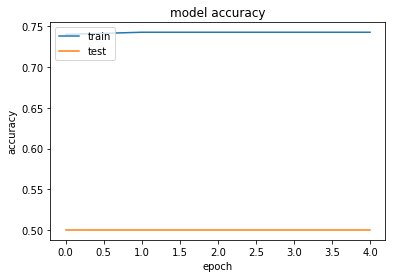

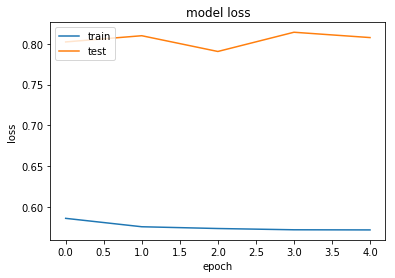

In [23]:
import matplotlib.pyplot as plt

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

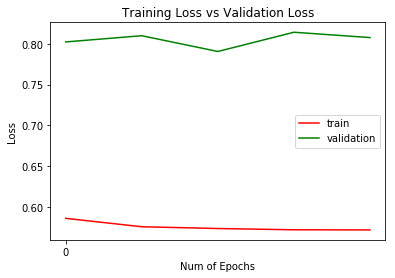

In [24]:
import numpy as np
plt.figure(1)
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')
plt.xticks(np.arange(0, num_epochs+1, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [25]:
predict_and_report(train_generator, model)
predict_and_report(validation_generator, model)

Accuracy: 0.7429064417177914
Area Under the Receiver Operating Characteristic Curve: 0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1341
          1       0.74      1.00      0.85      3875

avg / total       0.55      0.74      0.63      5216



/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.5
Area Under the Receiver Operating Characteristic Curve: 0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.50      1.00      0.67         8

avg / total       0.25      0.50      0.33        16



In [26]:
model.layers

In [27]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [28]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/1 [==============================] - 0s 265ms/step
No of errors = 8/16


Confusion matrix, without normalization
[[0 8]
 [0 8]]


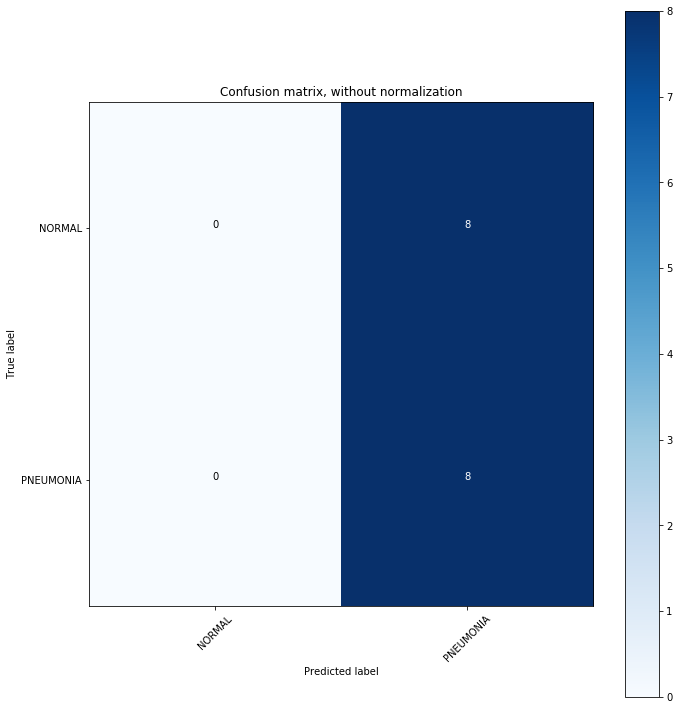

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix, without normalization')

In [38]:
import cv2
from random import randint


test_image = cv2.imread('data/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

AxesImage(72,54;446.4x326.16)


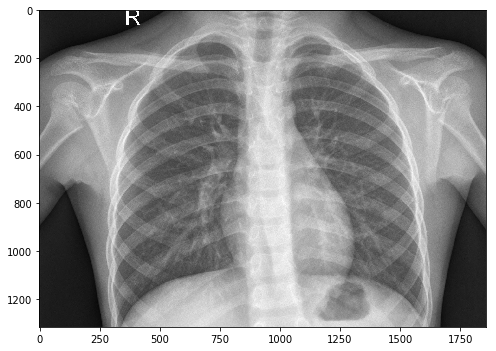

In [40]:
print(plt.imshow(test_image))

In [43]:
# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.resize(test_image, (img_height, img_width))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255

In [44]:
print(test_image.shape)

(75, 75)


AxesImage(72,54;446.4x326.16)


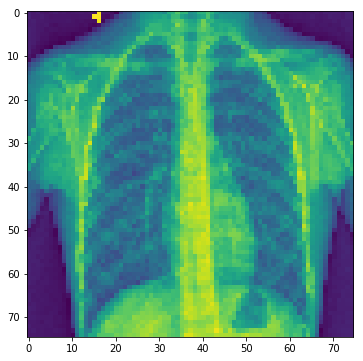

In [45]:
print(plt.imshow(test_image))

In [46]:
test_image = np.expand_dims(test_image, axis=3)
test_image = np.expand_dims(test_image, axis=0)
print (test_image.shape)

(1, 75, 75, 1)


/home/sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


In [47]:
print((model.predict(test_image)))

[[0.27387115 0.7261289 ]]


In [48]:
print(model.predict_classes(test_image))

[1]


In [51]:
from keras import backend as K

def getfeaturemaps(model, layer_idx, x_batch):
    get_activations = K.function([model.layers[0].input,
                                  K.learning_phase()],
                                [model.layers[layer_idx].output,])
    activations = get_activations([x_batch, 0])
    return activations

Using TensorFlow backend.


In [79]:
# Playaround with numbers here

layer_num = 5
filter_num = 3

In [ ]:
# Note: If you get any eeror on below cell, rerun the model definition again. model = Sequential() .....

In [74]:
activations = getfeaturemaps(model, int(layer_num), test_image)

In [75]:
print(np.shape(activations))
feature_maps = activations[0][0]

(1, 1, 37, 37, 64)


In [76]:
print(feature_maps.shape)

(37, 37, 64)


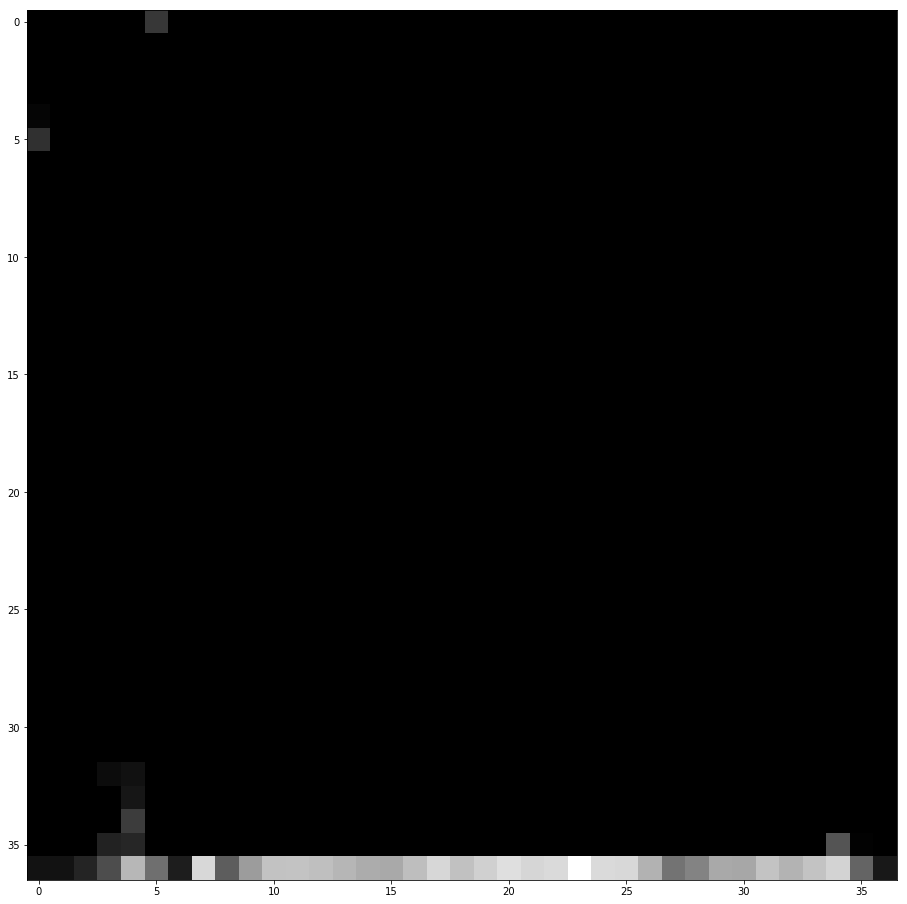

In [77]:
fig = plt.figure(figsize=(16, 16))
plt.imshow(feature_maps[:,:,filter_num], cmap='gray')

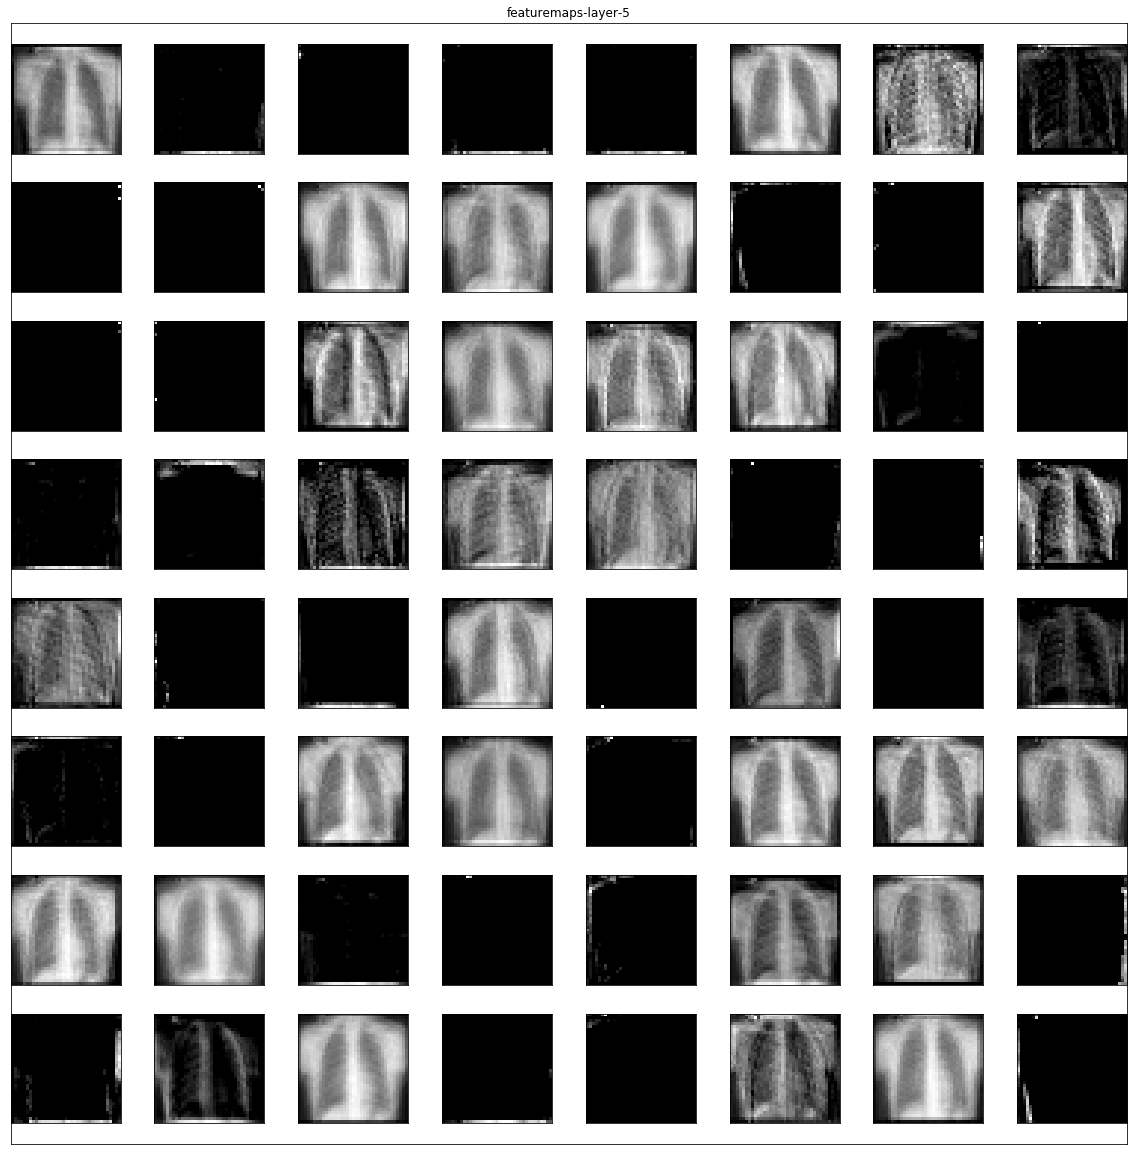

In [78]:
num_of_featuremaps = feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))

for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(feature_maps[:,:,i],cmap='gray')
    plt.tight_layout()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()